In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from pyHSICLasso import HSICLasso
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import pandas as pd
import shap
from nilearn import plotting

In [2]:
# Load data and identify the classes
static_fc_data = scipy.io.loadmat('Static_functional_connectivity_ptsd_dc_filt.mat')
sfc_controls = static_fc_data['conn_sfc_dc_filt_controls']  # (125, 125, 56)
sfc_ptsd = static_fc_data['conn_sfc_dc_filt_ptsd']         # (125, 125, 34)
sfc_pcsptsd = static_fc_data['conn_sfc_dc_filt_pcsptsd']   # (125, 125, 84)

# Load the behavioral data
behavioral_df = pd.read_csv('PTSD_Behavioral_measures.csv')

# Load the brain region data
channels_df = pd.read_csv('channels-125.csv')
roi_names = channels_df["Channel region (brief)"].values
coordinates = channels_df[['x-coordinate', 'y-coordinate', 'z-coordinate']].values

In [3]:
# Prepare the Data
# Categorize PCL5 scores into severity groups
def categorize_pcl5(pcl5_score):
    if 0 <= pcl5_score <= 25:
        return 0
    elif 26 <= pcl5_score <= 50:
        return 1
    elif 51 <= pcl5_score <= 75:
        return 2
    elif 76 <= pcl5_score <= 100:
        return 3

# Apply categorization to PCL5 scores
behavioral_df['PCL5_Category'] = behavioral_df['PCL5 score'].apply(categorize_pcl5)

In [4]:
# Extract upper triangle (excluding diagonal) from connectivity matrices
def extract_upper_triangle(connectivity_matrices):
    n_regions = connectivity_matrices.shape[0]
    n_subjects = connectivity_matrices.shape[2]
   
    # Get upper triangle indices
    upper_idx = np.triu_indices(n_regions, k=1)
   
    # Extract features for each subject
    features = np.zeros((n_subjects, len(upper_idx[0])))
    for i in range(n_subjects):
        features[i] = connectivity_matrices[upper_idx[0], upper_idx[1], i]
   
    return features

# Extract features
controls_features = extract_upper_triangle(sfc_controls)  # (56, 7750)
ptsd_features = extract_upper_triangle(sfc_ptsd)          # (34, 7750)
pcsptsd_features = extract_upper_triangle(sfc_pcsptsd)    # (84, 7750)

# Combine features into a single array
fc_features_all = np.concatenate([controls_features, ptsd_features, pcsptsd_features])  # (174, 7750)

# Combine features into a DataFrame
features = pd.DataFrame(fc_features_all)

# Add PCL5 categories as the target variable
features['PCL5_Category'] = behavioral_df['PCL5_Category'].values

In [5]:
# Split the Data
X = features.drop('PCL5_Category', axis=1)
y = features['PCL5_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y
                                                    )

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (139, 7750), Testing set: (35, 7750)


In [6]:
# Create feature names (node pairs)
n_regions = sfc_controls.shape[0]
upper_idx = np.triu_indices(n_regions, k=1)
# Map feature names to actual ROI names
feature_names = [
    f"{roi_names[i]}_{roi_names[j]}"
    for i, j in zip(upper_idx[0], upper_idx[1])
]

In [7]:
# HSIC Lasso for multi-class classification
# We'll perform one-vs-rest HSIC Lasso for each class
# First convert labels to one-hot encoding
n_classes = len(np.unique(y))
y_train_onehot = np.zeros((len(y_train), n_classes))
for i in range(n_classes):
    y_train_onehot[:, i] = (y_train == i).astype(float)

In [8]:
# Number of top features to select per class
n_select = 200

# Initialize HSIC Lasso
hsic_lasso = HSICLasso()

# Store selected features for each class
all_selected_features = {}
selected_feature_indices = set()

for class_idx in range(n_classes):
    print(f"\nPerforming HSIC Lasso for Class {class_idx}")
    
    # Use the current class column as target
    y_class = y_train_onehot[:, class_idx]
    
    # Fit HSIC Lasso
    hsic_lasso.input(X_train_scaled, y_class)
    hsic_lasso.classification(num_feat=n_select, B=139)
    
    # Get selected feature indices
    selected = hsic_lasso.get_index()
    selected_feature_indices.update(selected)
    
    # Get feature scores
    scores = hsic_lasso.get_index_score()
    
    # Store selected features and their scores
    all_selected_features[f"Class_{class_idx}"] = {
        'features': [feature_names[idx] for idx in selected],
        'indices': selected,
        'scores': scores
    }
    
    print(f"Top {n_select} features for Class {class_idx}:")
    for i, idx in enumerate(selected):
        print(f"  {feature_names[idx]}: {scores[i]:.4f}")



Performing HSIC Lasso for Class 0
Block HSIC Lasso B = 139.
M set to 1.
Using Gaussian kernel for the features, Delta kernel for the outcomes.
Top 200 features for Class 0:
  'Caudate_Head_L'_'Postcentral_L': 0.1074
  'Postcentral_L'_'Olfactory': 0.0754
  'Frontal_Mid_Orb_L'_'Olfactory': 0.0696
  'Cuneus_R'_'Parietal_Inf_L': 0.0534
  'Frontal_Mid_R'_'Frontal_Inf_Oper_L': 0.0505
  'Calcarine_R'_'Occipital_Mid_L': 0.0484
  'Lingual_R'_'Lingual_L': 0.0414
  'Occipital_Sup_R'_'Frontal_Inf_Oper_R': 0.0396
  'SupraMarginal_R'_'Vermis_6': 0.0394
  'Frontal_Inf_Orb_L'_'Fusiform_R': 0.0382
  'Thalamus_L'_'Occipital_Mid_L': 0.0337
  'SupraMarginal_R'_'Vermis_1_2': 0.0322
  'Parietal_Inf_R'_'SupraMarginal_L': 0.0303
  'Caudate_L'_'SupraMarginal_L': 0.0300
  'Precentral_R'_'Occipital_Mid_R': 0.0283
  'Frontal_Inf_Orb_L'_'Frontal_Sup_Medial_L': 0.0279
  'Frontal_Sup_Medial_R'_'Parietal_Inf_L': 0.0274
  'Precentral_R'_'Temporal_Inf_R': 0.0270
  'SupraMarginal_R'_'Caudate_R': 0.0252
  'SupraMarginal

In [9]:
def analyze_feature_distribution(all_selected_features, n_classes):
    # Create dictionary to store feature occurrences
    feature_occurrence = {}
    
    # Count occurrences of each feature across classes
    for class_idx in range(n_classes):
        features = all_selected_features[f"Class_{class_idx}"]['features']
        for feature in features:
            if feature not in feature_occurrence:
                feature_occurrence[feature] = set()
            feature_occurrence[feature].add(class_idx)
    
    # Count features by occurrence 
    class_specific = {i: 0 for i in range(n_classes)}  # Features unique to each class
    class_pairs = {(i, j): 0 for i in range(n_classes) for j in range(i+1, n_classes)}  # Features shared by pairs
    class_triplets = {(i, j, k): 0 for i in range(n_classes) 
                     for j in range(i+1, n_classes)
                     for k in range(j+1, n_classes)}  # Features shared by three classes
    shared_by_all = 0  # Features shared by all classes  
    
    for feat, classes in feature_occurrence.items():
        classes = sorted(list(classes))
        if len(classes) == 1:
            class_specific[classes[0]] += 1
        elif len(classes) == 2:
            class_pairs[tuple(classes)] += 1
        elif len(classes) == 3:
            class_triplets[tuple(classes)] += 1
        elif len(classes) == n_classes:
            shared_by_all += 1
    
    # Print numerical summary
    print("\nFeatures unique to each class:")
    for class_idx, count in class_specific.items():
        print(f"Class {class_idx}: {count}")
        
    print("\nFeatures shared between pairs:")
    for (c1, c2), count in class_pairs.items():
        print(f"Class {c1} and {c2}: {count}")
        
    print("\nFeatures shared between three classes:")
    for (c1, c2, c3), count in class_triplets.items():
        print(f"Class {c1}, {c2} and {c3}: {count}")
        
    print(f"\nFeatures shared by all classes: {shared_by_all}")
    print(f"Total unique features: {len(feature_occurrence)}")

# Run the analysis
feature_analysis = analyze_feature_distribution(all_selected_features, n_classes)


Features unique to each class:
Class 0: 123
Class 1: 89
Class 2: 103
Class 3: 98

Features shared between pairs:
Class 0 and 1: 10
Class 0 and 2: 5
Class 0 and 3: 7
Class 1 and 2: 16
Class 1 and 3: 15
Class 2 and 3: 10

Features shared between three classes:
Class 0, 1 and 2: 1
Class 0, 1 and 3: 1
Class 0, 2 and 3: 2
Class 1, 2 and 3: 1

Features shared by all classes: 0
Total unique features: 481


In [10]:
# Get all unique selected features
all_features = []
for class_data in all_selected_features.values():
    all_features.extend(class_data['features'])
unique_features = list(set(all_features))

# Extract unique selected features
unique_selected_indices = list(selected_feature_indices)
X_train_selected = X_train_scaled[:, unique_selected_indices]
X_test_selected = X_test_scaled[:, unique_selected_indices]

# 2. Split into train/validation/test
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42
)

# 3. Define models and parameter grids
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'MLP': MLPClassifier(max_iter=500, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

param_grids = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'SVM': {'C': [0.1, 1], 'kernel': ['linear', 'rbf']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5]},
    'Gradient Boosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]},
    'XGBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
}

# 4. Train and validate models
results = {}
for name, model in models.items():
    # Hyperparameter tuning
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_final, y_train_final)
    best_model = grid_search.best_estimator_
    
    # Validation evaluation
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Store results
    results[name] = {
        'model': best_model,
        'val_accuracy': val_accuracy,
        'best_params': grid_search.best_params_
    }


# Create a table to store results

results_table = []

# Evaluate all models on the test set
for name in models:
    model = results[name]['model'].fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    results_table.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results_table)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0        Random Forest  0.885714   0.884957  0.885714  0.880544
1                  SVM  0.971429   0.974603  0.971429  0.971517
2                  MLP  0.914286   0.923232  0.914286  0.914312
3  Logistic Regression  0.971429   0.974603  0.971429  0.971517
4  K-Nearest Neighbors  0.600000   0.550216  0.600000  0.545910
5    Gradient Boosting  0.742857   0.733949  0.742857  0.711617
6              XGBoost  0.885714   0.909066  0.885714  0.881615


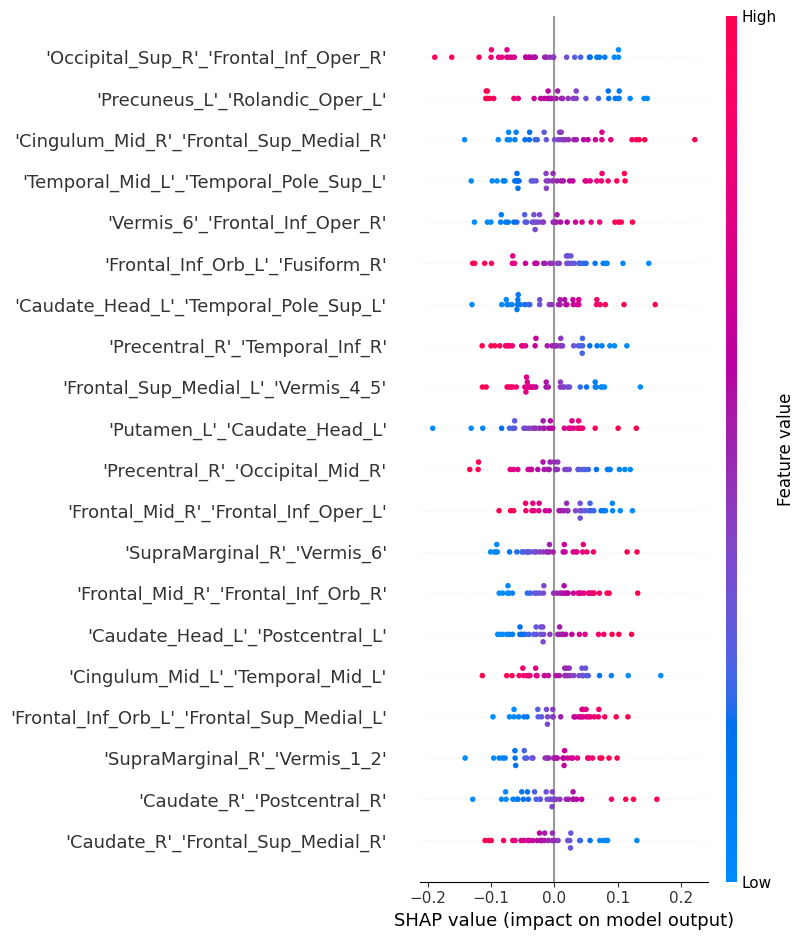

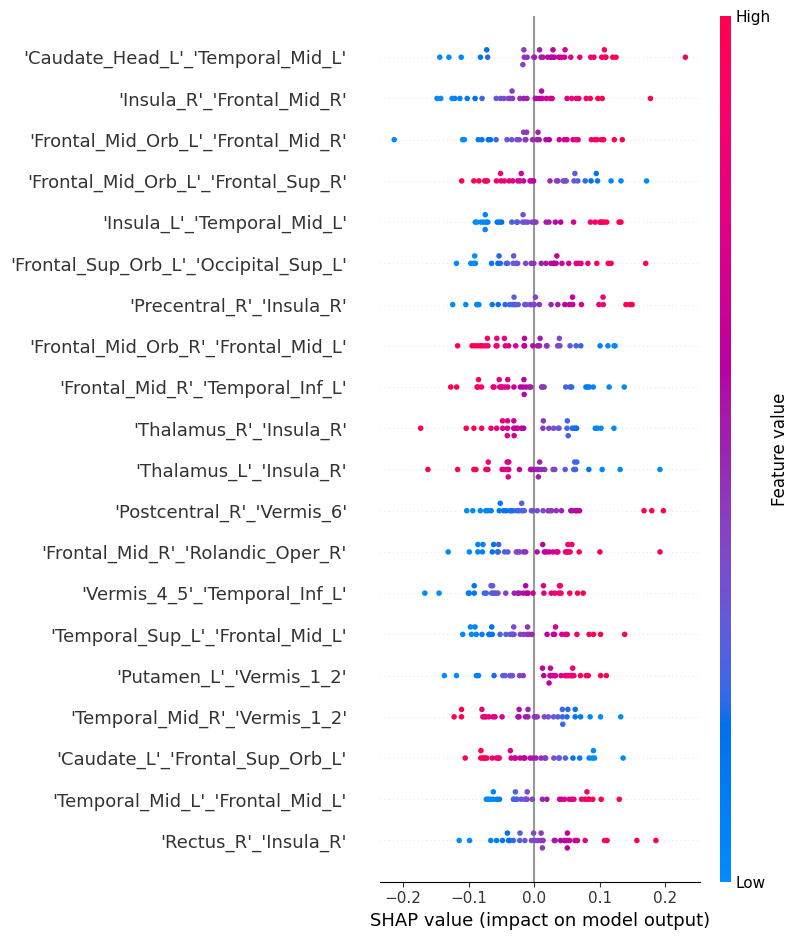

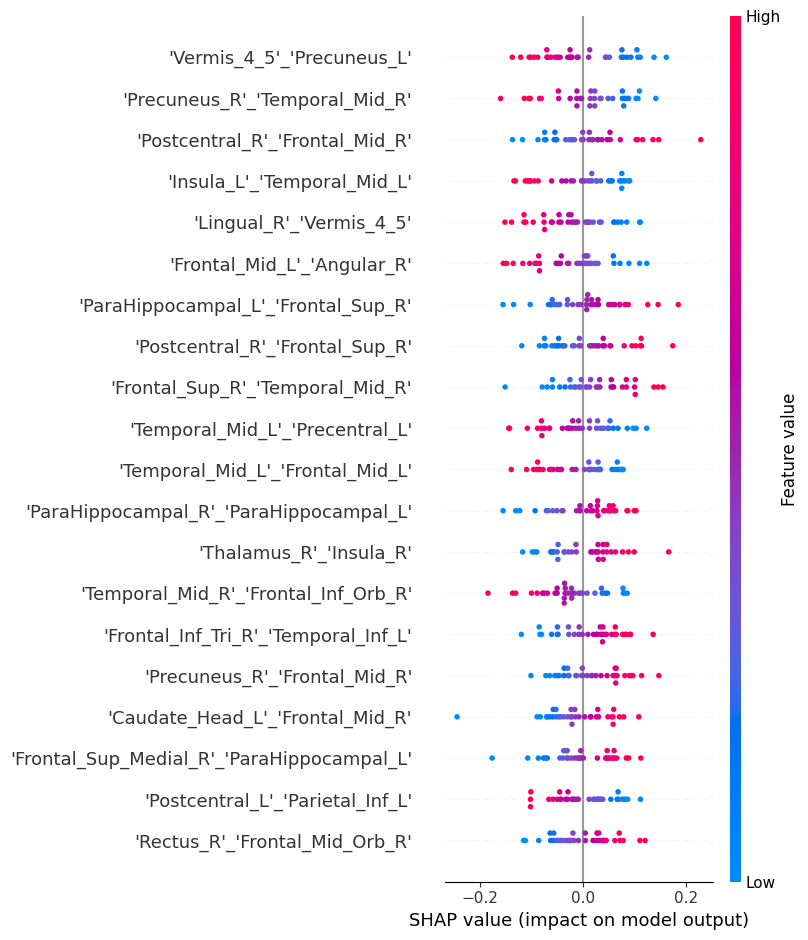

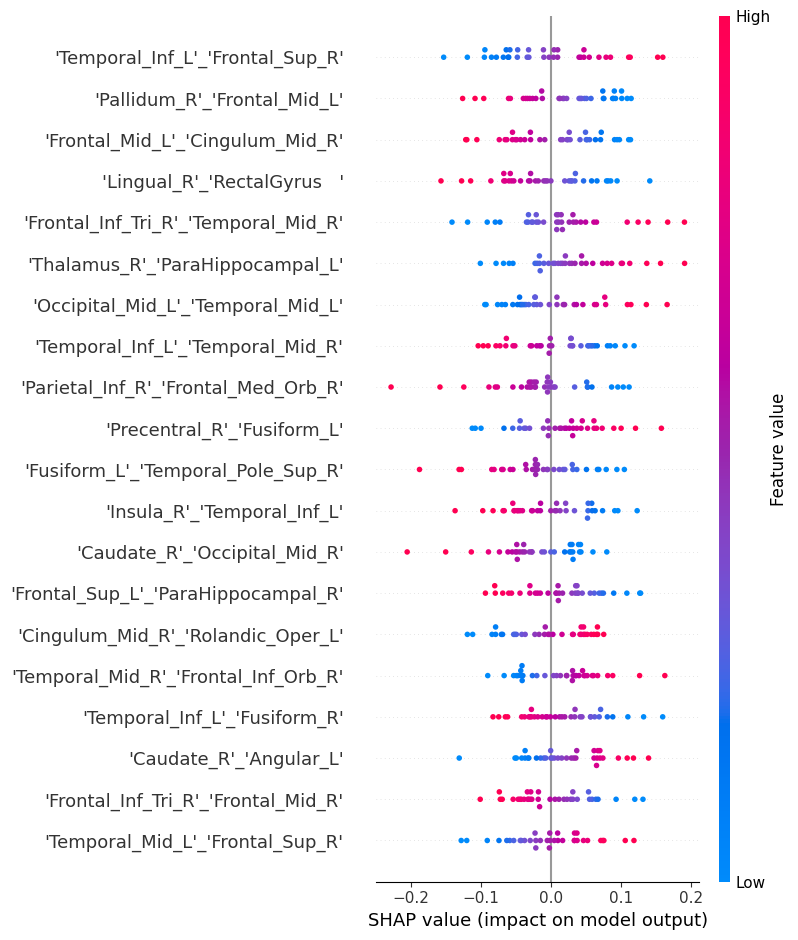

In [11]:
# Get the model and data
log_reg_model = results['Logistic Regression']['model']
selected_feature_names = [feature_names[idx] for idx in unique_selected_indices]
class_names = log_reg_model.classes_

# Compute SHAP values for the logistic regression model
explainer = shap.Explainer(log_reg_model, X_train_selected, feature_names=selected_feature_names)
shap_values = explainer(X_test_selected)

# Reshape SHAP values to expected format (list of arrays per class)
shap_values_per_class = [shap_values.values[:, :, i] for i in range(len(class_names))]

# Save as CSV files
for i, class_name in enumerate(class_names):
    pd.DataFrame(shap_values_per_class[i], 
                 columns=selected_feature_names).to_csv(f"shap_values_class_{class_name}.csv",
        index=False
    )

# Plot each class separately
for i, class_name in enumerate(log_reg_model.classes_):
    shap.summary_plot(
        shap_values_per_class[i],
        X_test_selected[:35],
        feature_names=selected_feature_names,
        title=f"Class {class_name}",
        show=False,
    )
    plt.show()


Visualizing class 0...


<Figure size 1200x600 with 0 Axes>

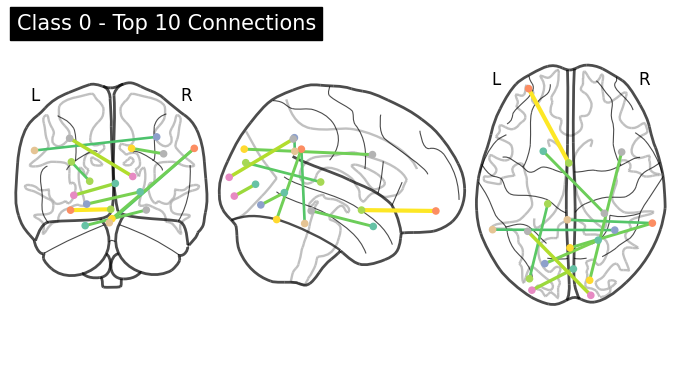


Visualizing class 1...


<Figure size 1200x600 with 0 Axes>

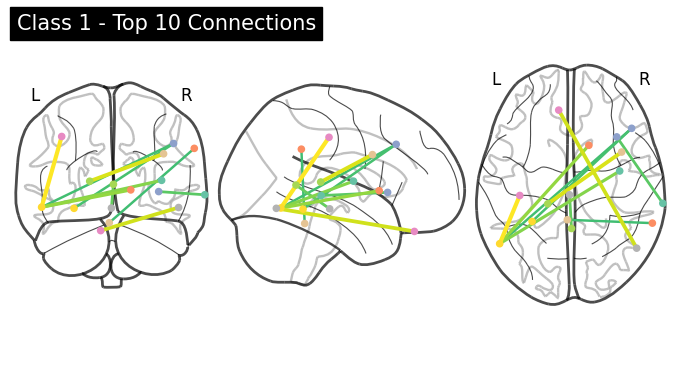


Visualizing class 2...


<Figure size 1200x600 with 0 Axes>

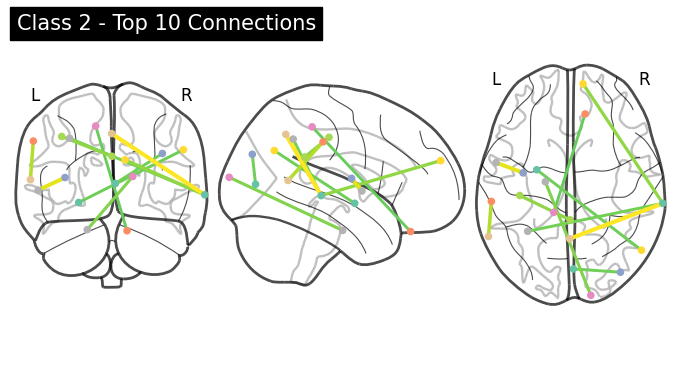


Visualizing class 3...


<Figure size 1200x600 with 0 Axes>

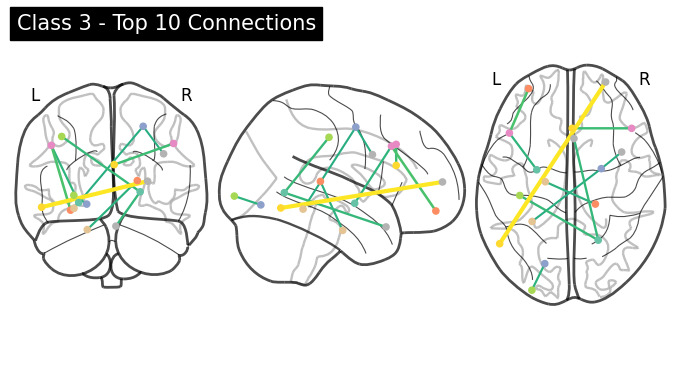

In [12]:
# Prepare class-specific connectivity matrices
n_rois = sfc_controls.shape[0]
n_classes = 4
class_connectivity = [np.zeros((n_rois, n_rois)) for _ in range(n_classes)]

# Get the mapping between selected features and ROI pairs
# First create a dictionary mapping feature indices to ROI pairs

# For each class, use the stored scores from all_selected_features
for class_idx in range(n_classes):
    class_data = all_selected_features[f"Class_{class_idx}"]
    
    # Get the stored features, indices and scores for this class
    features = class_data['features']
    indices = class_data['indices']  # These are the original feature indices
    scores = class_data['scores']  # These are the importance scores
    
    # Map to ROI pairs using feature names instead of indices
    for feature_name, score in zip(features, scores):
        # Find the index of this feature in feature_names
        try:
            feature_idx = feature_names.index(feature_name)
            i, j = upper_idx[0][feature_idx], upper_idx[1][feature_idx]
            class_connectivity[class_idx][i, j] = score
            class_connectivity[class_idx][j, i] = score  # Symmetric
        except ValueError:
            print(f"Feature name {feature_name} not found in feature_names.")
            continue

# Create visualizations per class (top 10 connections)
for class_idx in range(n_classes):
    print(f"\nVisualizing class {class_idx}...")
    
    # Get top 10 connections
    conn_matrix = class_connectivity[class_idx]
    triu_indices = np.triu_indices_from(conn_matrix, k=1)
    sorted_conn = np.argsort(conn_matrix[triu_indices])[::-1]  # Descending order
    
    # Create mask for top 10
    top10_mask = np.zeros_like(conn_matrix)
    for idx in sorted_conn[:10]:
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        top10_mask[i,j] = 1
        top10_mask[j,i] = 1
    
    # Get nodes involved in top connections
    connected_nodes = np.unique(np.where(top10_mask)[0])
        
    selected_coords = coordinates[connected_nodes]
    selected_rois = roi_names[connected_nodes]
    reduced_matrix = conn_matrix[connected_nodes][:, connected_nodes]
    reduced_mask = top10_mask[connected_nodes][:, connected_nodes]
    
    # Create plot
    plt.figure(figsize=(12, 6))
    plotting.plot_connectome(
        reduced_matrix * reduced_mask,
        selected_coords,
        edge_threshold=0.01,  # Show all remaining connections
        node_color='auto',
        node_size=20,
        edge_cmap='viridis',
        title=f'Class {class_idx} - Top 10 Connections',
        display_mode='ortho'
    )
    
    plt.savefig(f'top10_class_{class_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Save connection details to CSV
    top_connections = []
    for idx in sorted_conn[:10]:
        i, j = triu_indices[0][idx], triu_indices[1][idx]
        top_connections.append({
            'ROI 1': roi_names[i],
            'ROI 2': roi_names[j],
            'Strength': conn_matrix[i,j],
            'x1': coordinates[i,0],
            'y1': coordinates[i,1],
            'z1': coordinates[i,2],
            'x2': coordinates[j,0],
            'y2': coordinates[j,1],
            'z2': coordinates[j,2]
        })
    
    pd.DataFrame(top_connections).to_csv(f'top10_connections_class_{class_idx}.csv', index=False)
